In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.tree import plot_tree



# Linear regression

In [2]:
def train_linear_regression(
    data: pd.DataFrame, 
    target: str, 
    alphas: list[int] = [0.1, 1, 10, 100],
    transformer: str = None,  # 'log', 'yeo-johnson', or None
    scaler: str = None,  # 'robust', 'standard', or None
    regularization: str = None,
    polynomial_degree: int = None,  # New parameter for polynomial features
    interaction_only: bool = False,  # New parameter to control interaction terms
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a linear regression model with optional regularization and polynomial features.
    Calculates R² correctly for transformed targets.
    Handles ordinal features with ordinal encoding.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset containing features and target
    target : str
        Name of the target variable column
    alphas : list[int]
        List of alpha values for regularization
    transformer : str
        Transformation for numerical features: 'log', 'yeo-johnson', or None
    scaler : str
        Scaling method for numerical features: 'robust', 'standard', or None
    regularization : str
        Regularization method: 'ridge', 'lasso', or None
    polynomial_degree : int
        If provided, adds polynomial features up to this degree
    interaction_only : bool
        If True, only interaction features are produced (no powers)
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    """
    X = data.drop(target, axis=1)
    
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    
    # Separate nominal categorical columns 
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Define ordinal mappings
    ordinal_mappings = {
        # Quality features (Ex, Gd, TA, Fa, Po)
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        
        # Overall quality and condition (1-10)
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        
        # Basement exposure
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        
        # Basement finish types
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    
    # Apply transformations to y
    y = data[target]
    use_log_transform = transformer == 'log'
    use_yeo_johnson = transformer == 'yeo-johnson'
    
    if use_log_transform:
        y = np.log1p(y)
        
    num_steps = []

    # Add polynomial features if specified
    if polynomial_degree is not None and polynomial_degree > 1:
        num_steps.append((
            'polynomial', 
            PolynomialFeatures(
                degree=polynomial_degree, 
                interaction_only=interaction_only, 
                include_bias=False
            )
        ))
    
    # Add transformer and scaler steps
    if transformer == 'log':
        num_steps.append(('transformer', FunctionTransformer(np.log1p, validate=True)))
        if scaler == 'robust':
            num_steps.append(('scaler', RobustScaler()))
        elif scaler == 'standard':
            num_steps.append(('scaler', StandardScaler()))

    elif transformer == 'yeo-johnson':
        if scaler == 'robust':
            num_steps.append(('scaler', RobustScaler()))
        elif scaler == 'standard':
            num_steps.append(('scaler', StandardScaler()))
        num_steps.append(('clipper', FunctionTransformer(lambda X: np.clip(X, -1e2, 1e2), validate=False)))
        num_steps.append(('transformer', PowerTransformer(method='yeo-johnson', standardize=False)))

    elif scaler == 'robust': #if there is no transformer but scaler is chosen.
        num_steps.append(('scaler', RobustScaler()))
    elif scaler == 'standard': #if there is no transformer but scaler is chosen.
        num_steps.append(('scaler', StandardScaler()))
    
    
    # Create the numeric pipeline
    if num_steps:
        num_pipeline = Pipeline(num_steps)
    else:
        num_pipeline = 'passthrough'
    
    # Create transformers for each ordinal feature
    ordinal_transformers = []
    for col in ordinal_columns:
        ordinal_transformers.append(
            (f'ord_{col}', 
                OrdinalEncoder(
                    categories=[list(ordinal_mappings[col].keys())],
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                ), 
                [col])
        )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            ('num', num_pipeline, numerical_columns)
        ] + ordinal_transformers
    )

    # Select appropriate regressor
    if regularization == 'ridge':
        regressor = Ridge()
        param_grid = {'regressor__alpha': alphas}
    elif regularization == 'lasso':
        regressor = Lasso(max_iter=1000000, tol=0.01, selection='random') # for better stability reduced tolerance and increase max_iter
        param_grid = {'regressor__alpha': alphas}
    else:
        regressor = LinearRegression()
        param_grid = {}

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if regularization in ['ridge', 'lasso']:
        grid_search = GridSearchCV(
            model, 
            param_grid, 
            cv=10, 
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        best_model = model
        best_params = {}

    # Transform predictions back if needed
    if use_log_transform:
        # Apply safe expm1 by clipping extreme values
        max_safe_value = 30  # log(max_safe_value) is about 1.3e13
        y_pred_clipped = np.clip(y_pred, -max_safe_value, max_safe_value)
        y_test_clipped = np.clip(y_test, -max_safe_value, max_safe_value)
        y_pred = np.expm1(y_pred_clipped)
        y_test = np.expm1(y_test_clipped)
    elif use_yeo_johnson and y_test.min() >= 0:
        # Yeo-Johnson doesn't need inverse transform for positive values unless standardized
        pass
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Get feature importances - must handle the case where polynomial features are used
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        coef = best_model.named_steps['regressor'].coef_
        
        # Get feature names from the preprocessor
        try:
            # For scikit-learn >=1.0
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            # Build feature names manually
            feature_names = []
            
            # Add one-hot encoded nominal features
            if nominal_columns:
                feature_names.extend(
                    best_model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(nominal_columns)
                )
            
            # Add numerical features with polynomial features if used
            if polynomial_degree is not None and polynomial_degree > 1:
                num_transformer = best_model.named_steps['preprocessor'].named_transformers_['num']
                poly_transformer = None
                for name, transformer in num_transformer.steps:
                    if name == 'polynomial':
                        poly_transformer = transformer
                        break
                
                if poly_transformer:
                    feature_names.extend(
                        poly_transformer.get_feature_names_out(numerical_columns)
                    )
                else:
                    feature_names.extend(numerical_columns)
            else:
                feature_names.extend(numerical_columns)
            
            # Add ordinal features
            feature_names.extend(ordinal_columns)
        
        # Ensure the number of features matches the coefficients
        if len(feature_names) != len(coef):
            # If there's a mismatch, use generic feature names
            feature_names = [f'feature_{i}' for i in range(len(coef))]
        
        # Create coefficients DataFrame
        coefficients = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(coef),
            'value': coef
        }).sort_values('importance', ascending=False)
    else:
        coefficients = pd.DataFrame({
            'feature': ['N/A'],
            'importance': [0],
            'value': [0]
        })

    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': coefficients,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [64]:
df = pd.read_csv('data/train_rm_OL.csv') # in here outliers are removed
# df = pd.read_csv('data/train_cleaned.csv')


trans_options = [ 'log']  # 'yeo-johnson',
scaler_options = [None, 'robust'] #'stadard',
regularization_options = [None, 'ridge', 'lasso'] #'lasso',

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    for scaler in scaler_options:
        for regularization in regularization_options:
            alphas = [1, 10, 100, 1000, 10000] if regularization == 'ridge' else [0.0001, 0.001, 0.01, 0.1] if regularization == 'lasso' else None
            results = train_linear_regression(
                data=df,
                target='SalePrice',
                transformer=trans,
                scaler=scaler,
                regularization=regularization,
                alphas=alphas,  # Pass alphas if regularization is used
                polynomial_degree=None,
                # interaction_only=False
            )

            print(f'Results with transformer {trans}, scaler {scaler}, and regularization {regularization}:')
            for metric, value in results['performance'].items():
                print(f"{metric}: {value}")
            if regularization:
                print('The best alpha=', results['best_params']['regressor__alpha'])
            print("=" * 30)

            # Store the best model
            if results['performance']['r2_score'] > best_r2:
                best_r2 = results['performance']['r2_score']
                best_result = (trans, scaler, regularization, results)

if best_result:
    best_trans, best_scaler, best_regularization, best_results = best_result
    print("Best Model:")
    print(f"Transformer: {best_trans}")
    print(f"Scaler: {best_scaler}")
    print(f"Regularization: {best_regularization}")
    print(f"Best R2 Score: {best_r2}")
    print("Best Model Performance:")
    for metric, value in best_results['performance'].items():
        print(f"{metric}: {value}")
    if best_regularization:
        print('The best alpha=', best_results['best_params']['regressor__alpha'])
else:
    print("No results found.")

Results with transformer log, scaler None, and regularization None:
root_mean_squared_error: 20479.033016011777
r2_score: 0.9305598980320494
Results with transformer log, scaler None, and regularization ridge:
root_mean_squared_error: 19472.817022082527
r2_score: 0.9372159939023468
The best alpha= 10
Results with transformer log, scaler None, and regularization lasso:
root_mean_squared_error: 20780.912440014356
r2_score: 0.9284975895890679
The best alpha= 0.001
Results with transformer log, scaler robust, and regularization None:
root_mean_squared_error: 20439.572217642697
r2_score: 0.9308272467753371
Results with transformer log, scaler robust, and regularization ridge:
root_mean_squared_error: 19660.59836535589
r2_score: 0.9359992710869875
The best alpha= 10
Results with transformer log, scaler robust, and regularization lasso:
root_mean_squared_error: 21041.709647245258
r2_score: 0.9266916398824991
The best alpha= 0.001
Best Model:
Transformer: log
Scaler: None
Regularization: ridge

The result for the best model:

In [15]:
# df = pd.read_csv('data/train_cleaned.csv')
df = pd.read_csv('data/train_rm_OL.csv')


results = train_linear_regression(
    data=df,
    target='SalePrice',
    transformer='log',  
    scaler='robust',            
    regularization='ridge',
    alphas = [1, 10, 100, 200, 500, 1000],
    # polynomial_degree=2,
    # interaction_only=False
)
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")
print('The best alpha=', results['best_params']['regressor__alpha'])
print("=" * 30)



root_mean_squared_error: 19797.471118105615
r2_score: 0.9351050512649575
The best alpha= 10


Some features engineering seem to improve the model slightly, but I will not proceed with developing this. Nonetheless it is quite amazing that by feature engineering we can probably get the R2 up to 0.94 if interaction terms are included.

In [81]:
df = pd.read_csv('data/train_rm_OL.csv')
# df = pd.read_csv('data/train_cleaned.csv')
df['BsmtFinSF1_squared'] = df['BsmtFinSF1'] ** 2
df['TotalBsmtSF_squared'] = df['TotalBsmtSF'] ** 2
df['GrLivArea_squared'] = df['GrLivArea'] ** 2




results = train_linear_regression(
    data=df,
    target='SalePrice',
    transformer='log',  
    scaler='robust',            
    regularization='ridge',
    alphas = [1, 10,  20, 50, 100, 200],
    # polynomial_degree=2,
    # interaction_only=True
)
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")
print('The best alpha=', results['best_params']['regressor__alpha'])
print("=" * 30)

root_mean_squared_error: 19660.59836535589
r2_score: 0.9359992710869875
The best alpha= 10


Removing outliers results in overall better performance of LR models, and we quickly identified how many outliers should be removed, so we have a best guess for more sophisticated models. This is perhaps a hint to use this dataset for training.

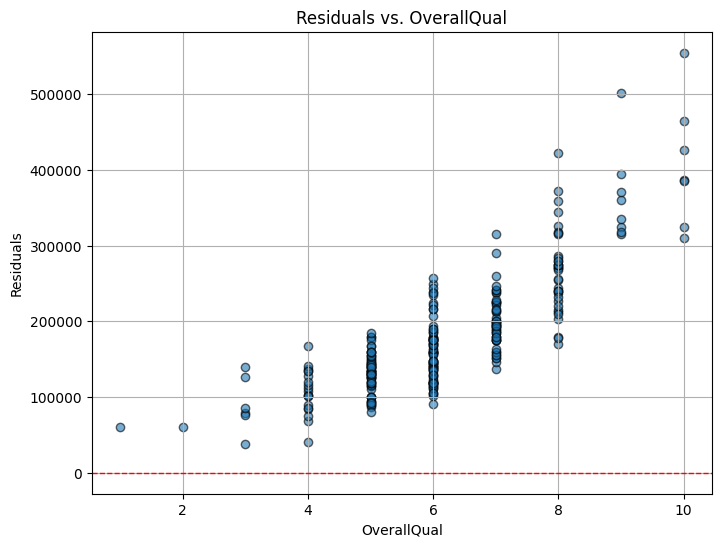

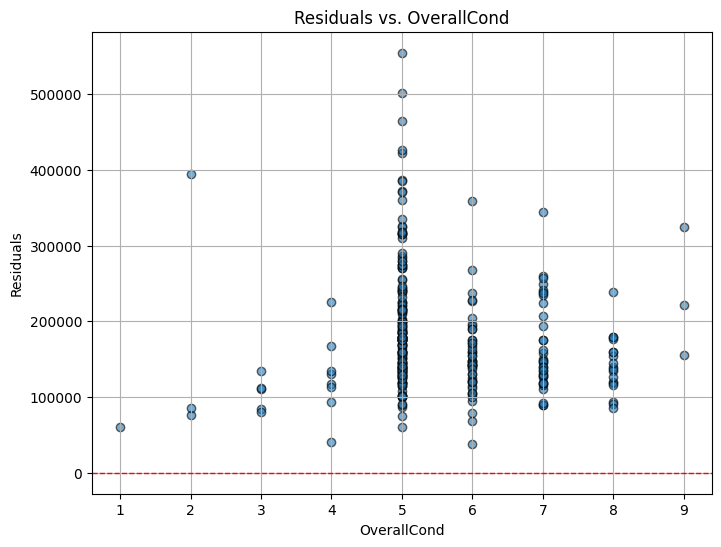

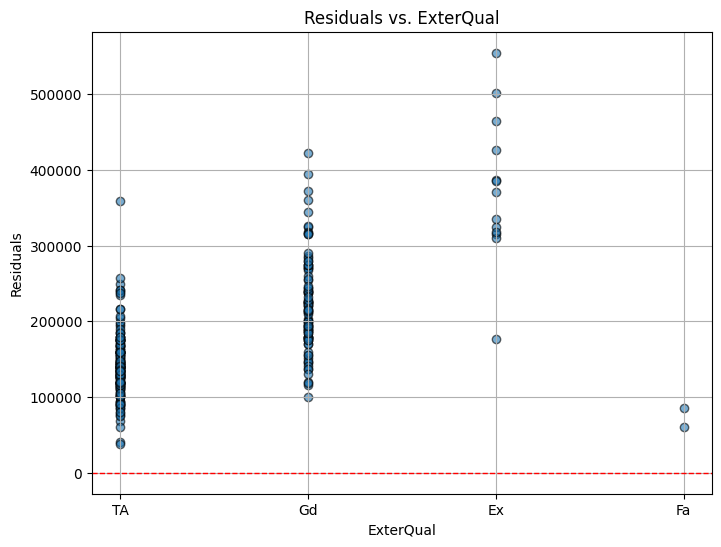

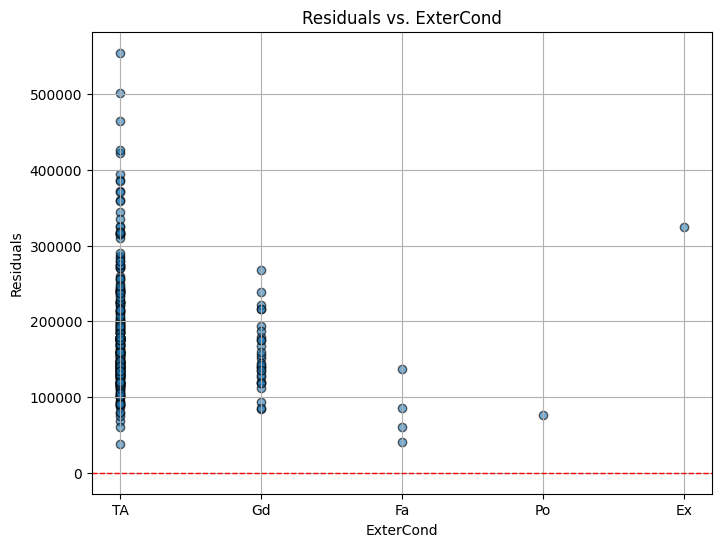

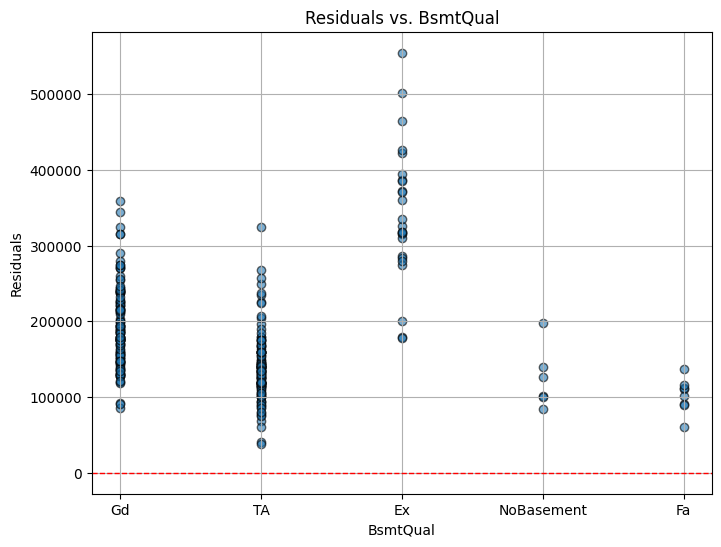

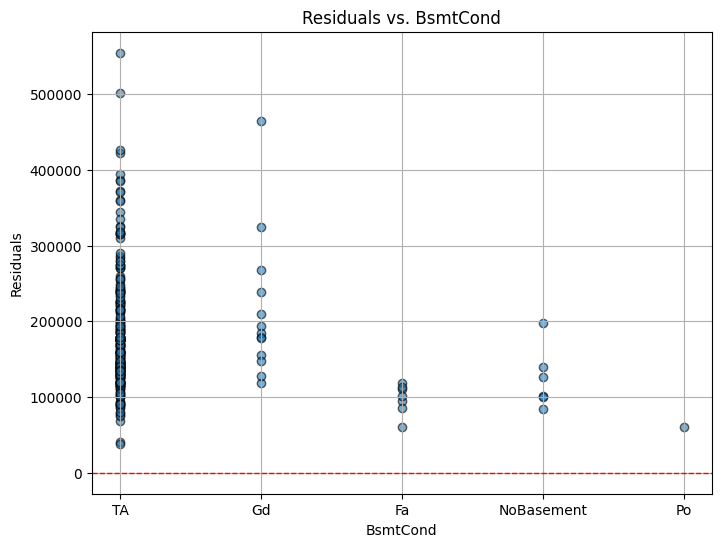

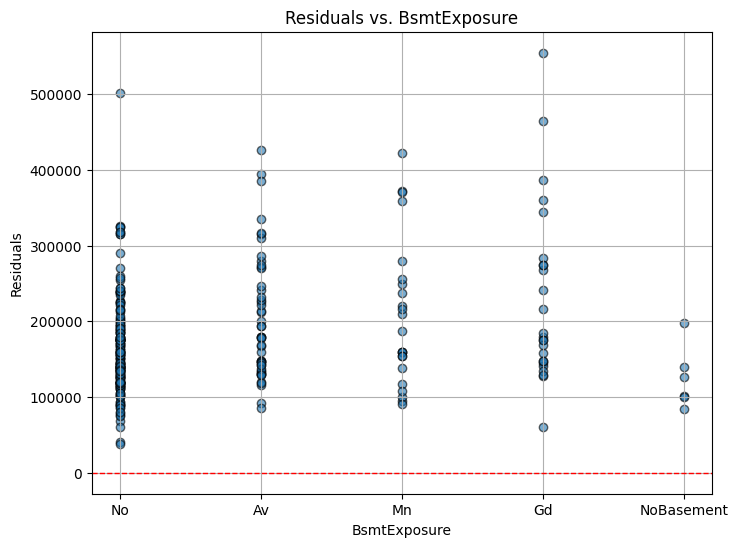

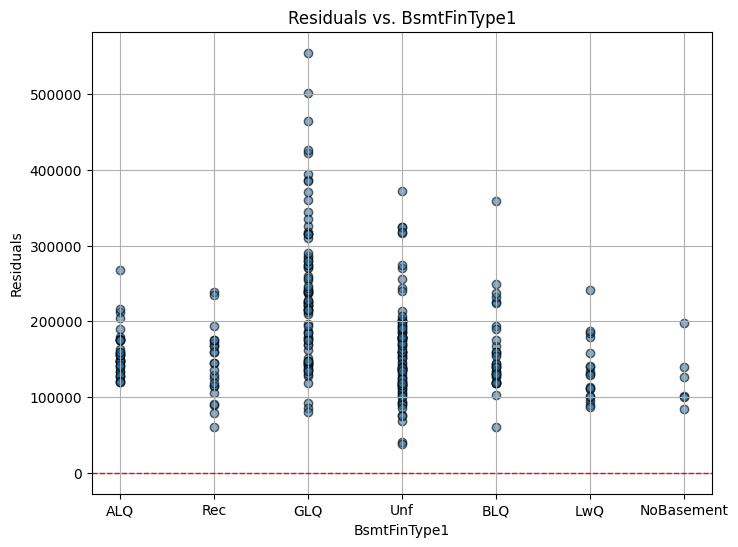

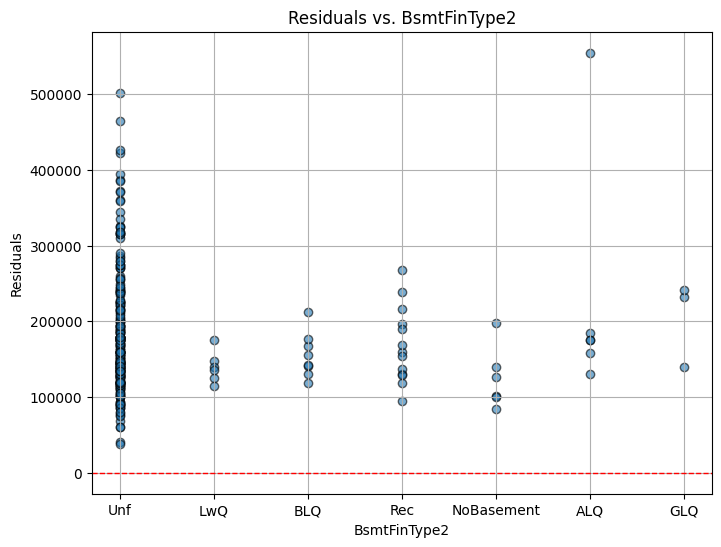

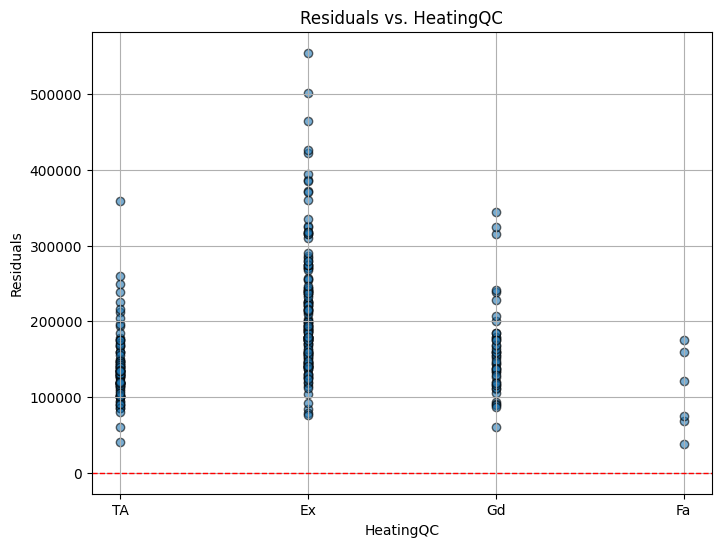

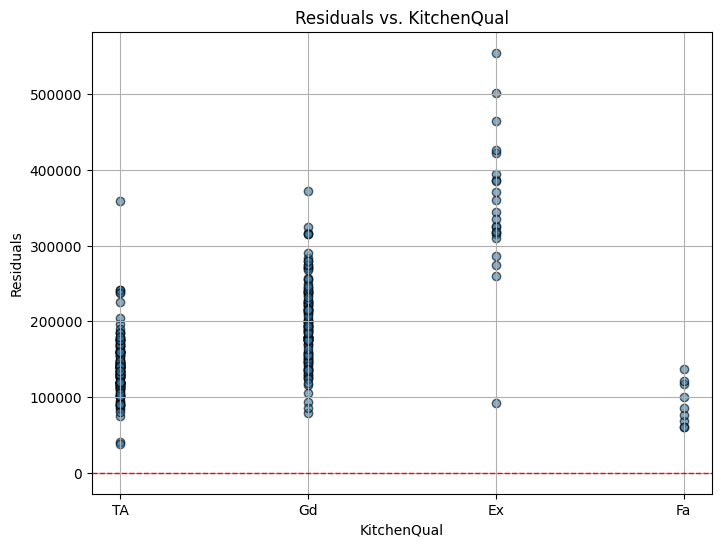

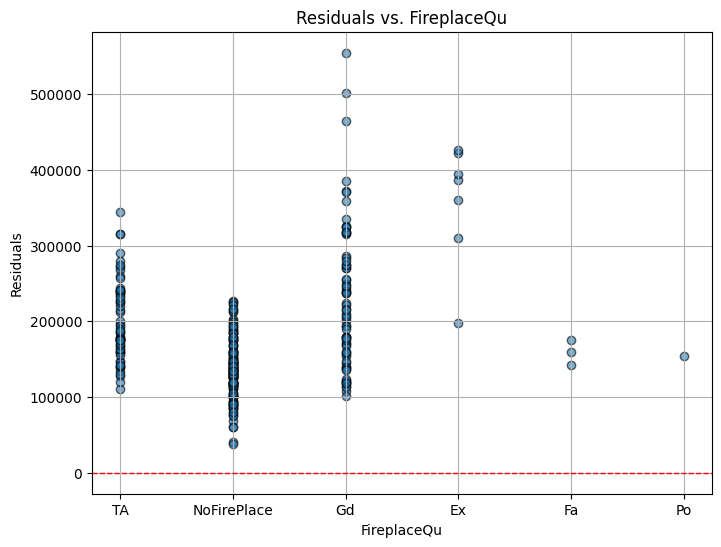

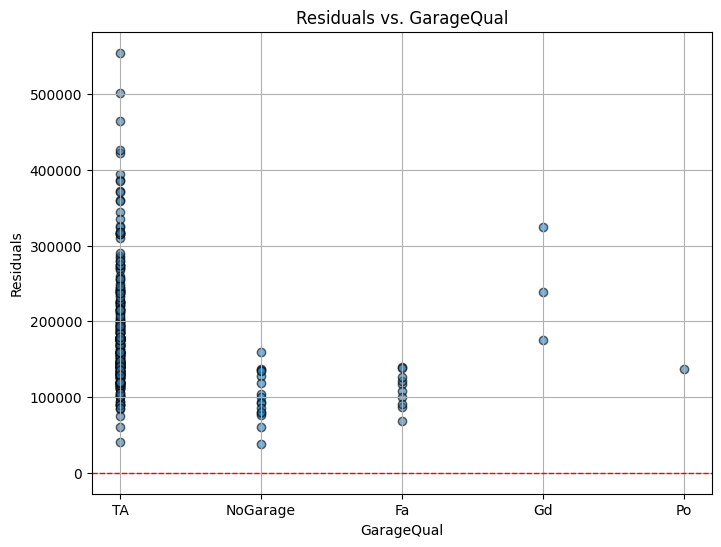

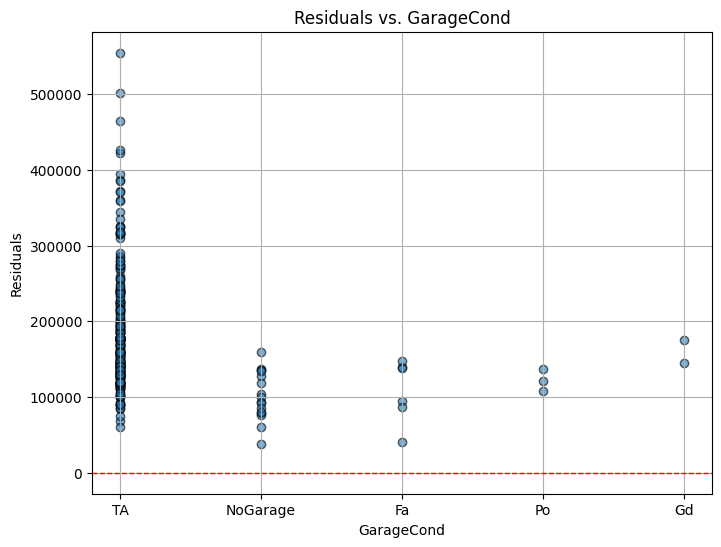

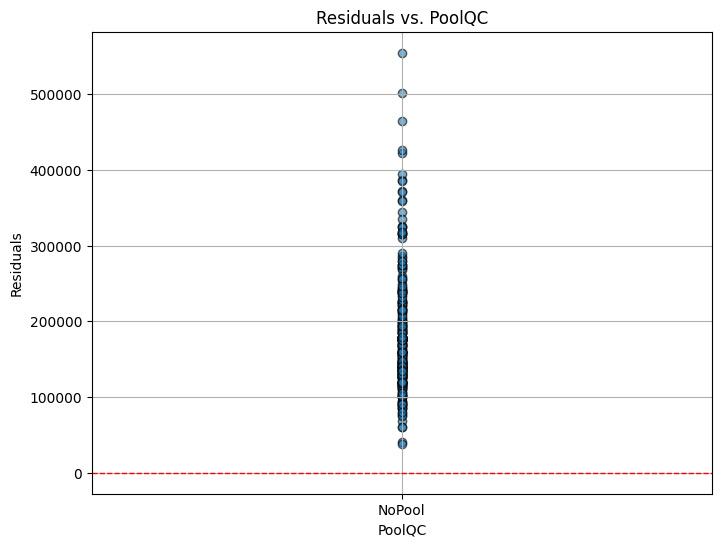

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_residuals_by_feature(model_output: dict, features: list = None):
    """
    Plot residuals (test set errors) versus specified features from the original test set.
    
    Parameters:
    -----------
    model_output : dict
        The dictionary returned by train_linear_regression. It should contain:
            - 'model': the trained Pipeline
            - 'test_data': a tuple (X_test, y_test)
    features : list, optional
        List of feature names (columns in X_test) to plot against the residuals.
        If None, a plot is generated for each feature in X_test.
        
    Notes:
    ------
    - This function uses the original X_test (i.e., before any transformation in the pipeline)
      so that the plots reflect the raw feature values.
    - If you have many features, you might want to supply a subset via the 'features' parameter.
    """
    # Unpack the test data and model from the output dictionary
    X_test, y_test = model_output['test_data']
    model = model_output['model']
    
    # Compute predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # If features are not specified, plot for every feature in X_test.
    if features is None:
        features = X_test.columns.tolist()
    
    # Plot residuals versus each specified feature
    for feature in features:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[feature], residuals, alpha=0.6, edgecolor='k')
        plt.xlabel(feature)
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs. {feature}")
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
        plt.grid(True)
        plt.show()

    
    
# plot_residuals_by_feature(results, ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd'])
plot_residuals_by_feature(results, ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'])

### Linear regression conclusions:

This result is pretty impresive for linear regression.

From above we can see, that the best R2 is obtained for data without outliers 

# Full scan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer, 
    PolynomialFeatures, PowerTransformer, OrdinalEncoder
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------
# Helper: Build a numeric pipeline based on a choice
# ----------------------------
def create_numeric_pipeline(choice):
    """
    Create a numeric pipeline based on the transformation choice.
    
    The pipeline always starts with a placeholder for polynomial features,
    then:
      - If choice=='log': applies np.log1p then a scaler (to be tuned via grid search)
      - If choice=='yeo-johnson': applies a scaler, a clipping function, then a PowerTransformer
      - Otherwise, just a scaler.
      
    The 'poly' and 'scaler' steps are set to 'passthrough' by default
    and can be overridden in the grid search.
    """
    steps = []
    # Step 1: polynomial features (default 'passthrough'; grid search can try a PolynomialFeatures transformer)
    steps.append(('poly', 'passthrough'))
    
    if choice == 'log':
        # Apply log transformation to numeric features
        steps.append(('log', FunctionTransformer(np.log1p, validate=True)))
        steps.append(('scaler', 'passthrough'))
    elif choice == 'yeo-johnson':
        steps.append(('scaler', 'passthrough'))
        # A clipper can help reduce the effect of extreme values before power transforming
        steps.append(('clipper', FunctionTransformer(lambda X: np.clip(X, -1e2, 1e2), validate=False)))
        steps.append(('power', PowerTransformer(method='yeo-johnson', standardize=False)))
    else:
        # No transformation; just a scaler (or none if scaler is set to passthrough)
        steps.append(('scaler', 'passthrough'))
    return Pipeline(steps)

# ----------------------------
# Main training function using GridSearchCV
# ----------------------------
def train_model_with_grid_search(
    data: pd.DataFrame, 
    target: str,
    param_grid,
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a regression model by scanning over preprocessing options and regressor types.
    
    This grid search will explore:
      - Three numeric processing pipelines (using a log transform, a yeo-johnson transform, or none)
      - For each numeric pipeline, whether to add polynomial features (degree=2) or not,
        and whether to apply a RobustScaler, StandardScaler, or no scaling.
      - Different regressors: Ridge, Lasso, or plain LinearRegression.
    
    The function returns a dictionary with the best model, performance metrics,
    best parameters, feature importances, and the train/test splits.
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    y = data[target].copy()
    y = np.log1p(y)
    
    # Define columns for different types of features
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Define ordinal mappings and create an encoder for each ordinal column
    ordinal_mappings = {
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    ordinal_transformers = []
    for col in ordinal_columns:
        ordinal_transformers.append(
            (f'ord_{col}', 
                OrdinalEncoder(
                    categories=[list(ordinal_mappings[col].keys())],
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                ), 
                [col])
        )
    
    # Build three options for numeric feature processing:

    
    # Build a ColumnTransformer that applies different transformations to different feature types.
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            # For numerical features, we start with one of our numeric pipelines.
            ('num', numeric_pipeline_options['none'], numerical_columns)
        ] + ordinal_transformers
    )
    
    #  placeholder 
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    
    
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Extract feature importances if available (e.g. using regressor coefficients)
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        coef = best_model.named_steps['regressor'].coef_
        try:
            # For scikit-learn >=1.0
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            # If that fails, build a list manually.
            feature_names = []
            if nominal_columns:
                feature_names.extend(
                    best_model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(nominal_columns)
                )
            feature_names.extend(numerical_columns)
            feature_names.extend(ordinal_columns)
        if len(feature_names) != len(coef):
            feature_names = [f'feature_{i}' for i in range(len(coef))]
        coefficients = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(coef),
            'value': coef
        }).sort_values('importance', ascending=False)
    else:
        coefficients = pd.DataFrame({
            'feature': ['N/A'],
            'importance': [0],
            'value': [0]
        })
    
    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': coefficients,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }







In [15]:
numeric_pipeline_options = {
    'log': create_numeric_pipeline('log'),
    'yeo-johnson': create_numeric_pipeline('yeo-johnson'),
    'none': create_numeric_pipeline(None)
}

param_grid = [
        {
            'preprocessor__num': [numeric_pipeline_options['log']],
            'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), 'passthrough'],
            'preprocessor__num__poly': [
                'passthrough', 
                PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            ],
            'regressor': [Ridge(), Lasso(max_iter=1000, tol=0.01, selection='random')],
            'regressor__alpha': [ 1, 10, 100, 1000, 10000]
        },
        {
            'preprocessor__num': [numeric_pipeline_options['log']],
            'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), 'passthrough'],
            'preprocessor__num__poly': [
                'passthrough', 
                PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            ],
            'regressor': [LinearRegression()]
        }
    ]

df = pd.read_csv('data/train_rm_OL.csv')  # replace with your file path
results = train_model_with_grid_search(df, target='SalePrice', param_grid=param_grid)

print("Best Model Performance:")
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")
print("\nBest Parameters:")
print(results['best_params'])
print("\nTop Feature Importances:")
print(results['feature_importances'].head(10))

Best Model Performance:
root_mean_squared_error: 0.12161745189771789
r2_score: 0.9091680773924601

Best Parameters:
{'preprocessor__num': Pipeline(steps=[('poly', 'passthrough'),
                ('log',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaler', 'passthrough')]), 'preprocessor__num__poly': 'passthrough', 'preprocessor__num__scaler': StandardScaler(), 'regressor': Ridge(), 'regressor__alpha': 10}

Top Feature Importances:
                   feature  importance     value
0         MSZoning_C (all)    0.109538 -0.109538
301              GrLivArea    0.094752  0.094752
33    Neighborhood_Crawfor    0.087028  0.087028
297            TotalBsmtSF    0.064556  0.064556
149         Functional_Typ    0.057231  0.057231
321            OverallQual    0.056692  0.056692
280  SaleCondition_Abnorml    0.056480 -0.056480
92     Exterior1st_BrkFace    0.056210  0.056210
49    Neighborhood_StoneBr    0.054847  0.054847
251     GarageYrBlt_2008.

# Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder

def train_decision_tree_regression(
    data: pd.DataFrame, 
    target: str, 
    max_depth: list[int] = [2, 3, 5, 7, 10],
    min_samples_splits: list[int] = [2, 5, 10],
    min_samples_leaf: list[int] = [1, 2, 4],
    max_features: list[int, float, str] = [None, 'sqrt', 'log2'],
    num_transformer: str = 'robust',
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a decision tree regression model with pruning and advanced preprocessing.
    Supports various numerical transformations and handles categorical features.
    Properly handles ordinal features using ordinal encoding.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset
    target : str
        Name of the target column
    pruning_depths : list
        Maximum depths to test for pruning
    min_samples_splits : list
        Minimum number of samples required to split an internal node
    num_transformer : str
        Numerical feature transformation method
        Options: 'robust', 'standard', 'log', 'log+robust', 'log+standard'
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : A dictionary containing model, performance metrics, 
           best parameters, and feature importances
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    
    # Define feature types
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    
    # Keep only ordinal columns that actually exist in the dataset
    ordinal_columns = [col for col in ordinal_columns if col in X.columns]
    
    # Separate remaining categorical columns (nominal)
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Define ordinal mappings
    ordinal_mappings = {
        # Quality features (Ex, Gd, TA, Fa, Po)
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        
        # Overall quality and condition (1-10)
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        
        # Basement exposure
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        
        # Basement finish types
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    
    # Log transformer for skewed features
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    
    # Determine scaling and target transformation
    y = data[target]
    use_log_transform = num_transformer in ['log', 'log+robust', 'log+standard']
    
    # Create numerical preprocessing pipeline
    if num_transformer == 'robust': 
        num_pipeline = RobustScaler()
    elif num_transformer == 'standard': 
        num_pipeline = StandardScaler()
    elif num_transformer == 'log+robust':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', RobustScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log+standard':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', StandardScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log':
        num_pipeline = log_transformer
        y = np.log1p(y)
    else:
        num_pipeline = 'passthrough'

    # Create transformers for each ordinal feature
    ordinal_transformers = []
    for col in ordinal_columns:
        if col in ordinal_mappings:
            ordinal_transformers.append(
                (f'ord_{col}', 
                 OrdinalEncoder(
                     categories=[list(ordinal_mappings[col].keys())],
                     handle_unknown='use_encoded_value',
                     unknown_value=-1
                 ), 
                 [col])
            )

    # Create preprocessor with one-hot encoder for nominal categories
    # and ordinal encoder for ordinal categories
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            ('num', num_pipeline, numerical_columns)
        ] + ordinal_transformers
    )

    param_grid = {
        'regressor__max_depth': max_depth,
        'regressor__min_samples_split': min_samples_splits,
        'regressor__min_samples_leaf': min_samples_leaf,
        'regressor__max_features': max_features
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=random_state))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=10, 
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    if use_log_transform:
        # Inverse transform predictions and actual values
        y_pred = np.expm1(y_pred)
        y_test = np.expm1(y_test)
        
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Get feature names from model - needs to be handled differently with ordinal features
    feature_names = []
    
    # Add one-hot encoded nominal features
    if nominal_columns:
        feature_names.extend(
            best_model.named_steps['preprocessor']
            .named_transformers_['cat']
            .get_feature_names_out(nominal_columns)
        )
    
    # Add numerical features
    feature_names.extend(numerical_columns)
    
    # Add ordinal features
    feature_names.extend(ordinal_columns)
    
    # Extract feature importances
    importances = best_model.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'type': ['Numerical' if col in numerical_columns else 
                 'Ordinal' if col in ordinal_columns else 
                 'Categorical' for col in feature_names]
    }).sort_values('importance', ascending=False)

    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': feature_importances,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [ ]:
# df = pd.read_csv('data/train_cleaned.csv')
df = pd.read_csv('data/train_rm_OL.csv')
trans_options = ['robust'] # this is the best preprocessing
# trans_options = ['robust', 'standard', 'log', 'log+robust', 'log+standard']

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    results_tree = train_decision_tree_regression(
        df, target='SalePrice', min_samples_splits=[10, 20], max_depth=[15, 20], max_features=[None],  num_transformer=trans
    )
    
    print(f'Results with preprocessing {trans}:')
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])
    
    # Store the best model
    if results_tree['performance']['r2_score'] > best_r2:
        best_r2 = results_tree['performance']['r2_score']
        best_result = (trans, results_tree)

# Print the best model at the end and visualize it
if best_result:
    trans, results_tree = best_result
    best_model = results_tree['model'].named_steps['regressor']  # Extract regressor from pipeline
    preprocessor = results_tree['model'].named_steps['preprocessor']  # Extract preprocessor from pipeline
    
    # Get transformed feature names
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop('SalePrice', axis=1).columns
    feature_names = preprocessor.get_feature_names_out()
    # (
    #     list(preprocessor.named_transformers_['cat'].get_feature_names_out()) +
    #     list(numerical_columns)
    # )

    print("Best model:")
    print(f"Preprocessing: {trans}")
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])

    # Visualizing the tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, filled=True, feature_names=feature_names)
    plt.show()


Trees are way worse than linear regression, which may indicate that non-linearities are not extreme in the dataset.